#                        Nasa_Mars_Rover_Project

In [1]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio

## Quick look on Data

- Reading some random images from test_dataset folder

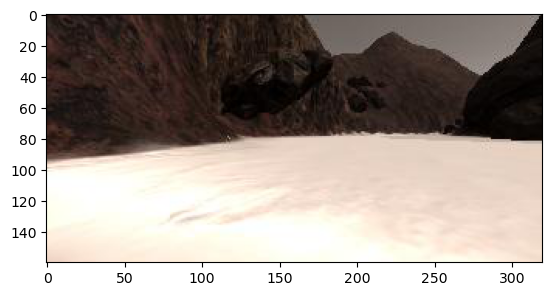

In [2]:
path = 'IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)



## Calibration Data

Read in and display example grid and rock sample calibration images. You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest.


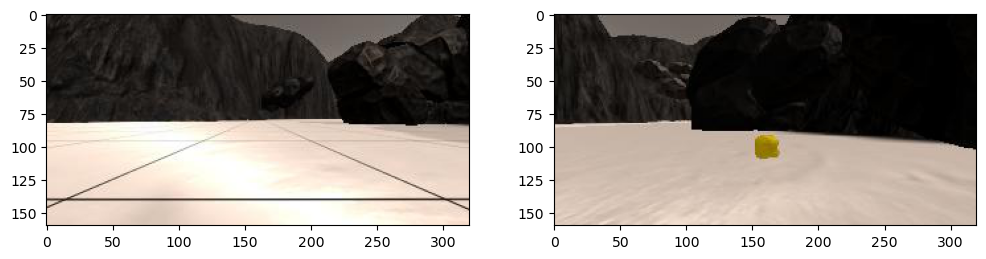

In [3]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = 'calibration_images/example_grid1.jpg'
example_rock = 'calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

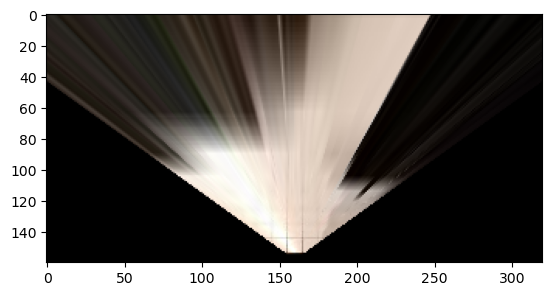

In [4]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)

## Color Thresholding

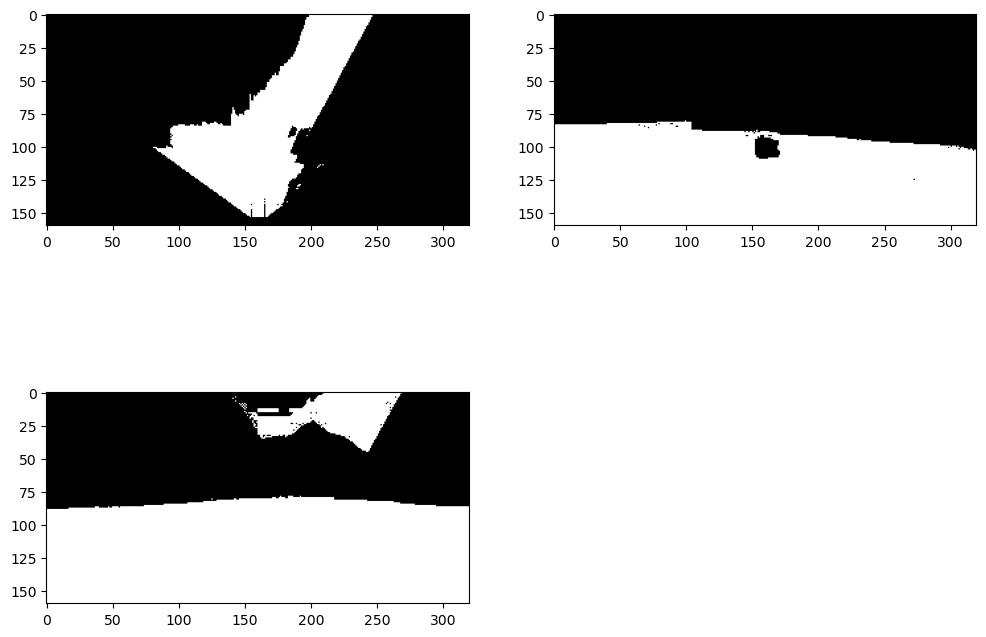

In [5]:
def color_thresh(img, rgb_thresh=(160, 160, 160), tgt=False, tol=(40,40,40)):
    # img                  transformed (warped) camera image array
    # rgb_thresh           tgt==False (default) return array where > rgb_thresh = True (1)
    #                      tgt==True  return array where rgb_thresh +/- rgb_thresh * tol = True (1)
    # tol                  when tgt==True, sets the tolerance +/- for a pixel to return true
    
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    
    # if tgt == True we are looking for samples so look for +/- from rgb_thresh
    if tgt:
        bool_array = (abs(img[:,:,0] - rgb_thresh[0]) < tol[0]) \
                   & (abs(img[:,:,1] - rgb_thresh[1]) < tol[1]) \
                   & (abs(img[:,:,2] - rgb_thresh[2]) < tol[2]) 
    
    # tgt is false, we are looking for nav terrain/obstacles
    else:    
        # Require that each pixel be above all three threshold values in RGB
        # above_thresh will now contain a boolean array with "True"
        # where threshold was met
        bool_array = (img[:,:,0] > rgb_thresh[0]) \
                   & (img[:,:,1] > rgb_thresh[1]) \
                   & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[bool_array] = 1
    # Return the binary image
    return color_select
nav_threshold = (190, 180, 160)
tgt_threshold = (185, 140, 15)
obs_threshold = (100, 100, 100)
threshed = color_thresh(warped,nav_threshold)
rock_thres = color_thresh(rock_img,tgt_threshold)
idx = np.random.randint(0, len(img_list)-1)
img = mpimg.imread(img_list[idx])
obs_thres = color_thresh(img, obs_threshold)

fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(threshed, cmap='gray')
plt.subplot(222)
plt.imshow(rock_thres, cmap='gray')
plt.subplot(223)
plt.imshow(obs_thres, cmap='gray')

## Coordinate Transformations

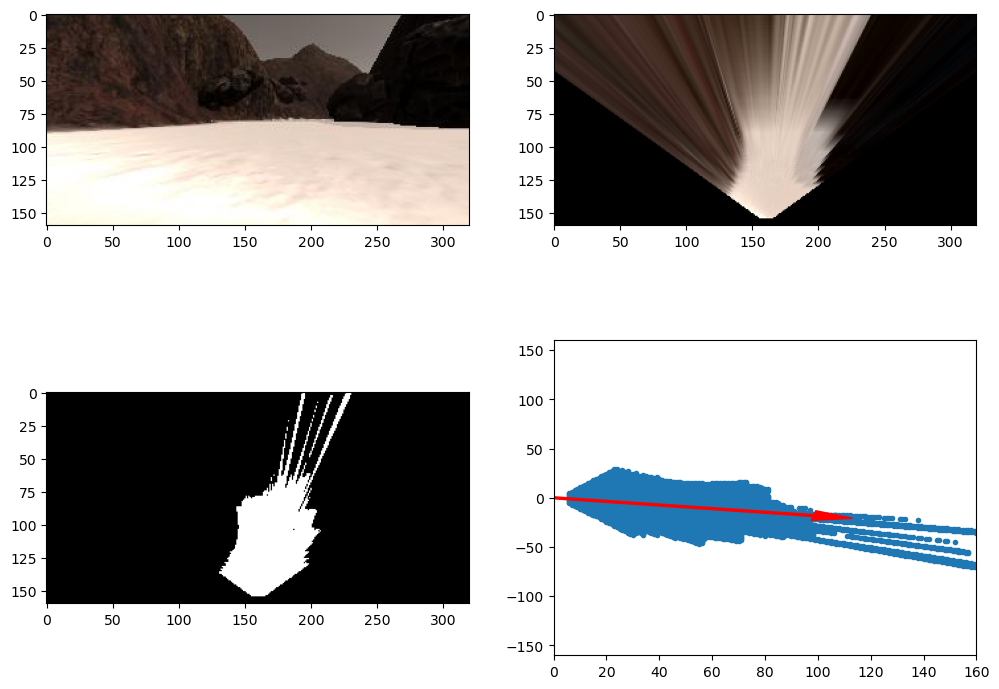

In [6]:
def rover_coords_(xpos, ypos, binary_img, offset):
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 + offset ).astype(np.float)
    return x_pixel, y_pixel
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float32)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)






# Finding Rock

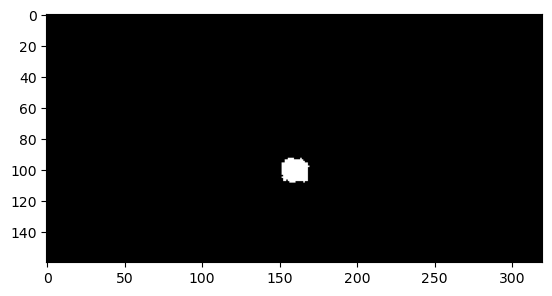

In [7]:
def rock_thresh(img):
    
    hsv_img=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    rock_lower = np.array([0,200,100])     # HSV lower limit for golden rocks
    rock_upper = np.array([179,255,255])   # HSV upper limit for golden rocks
    
    rock_t = cv2.inRange(hsv_img, rock_lower, rock_upper)
      
    return rock_t*255

image = rock_thresh(rock_img)*200
plt.imshow(image, cmap='gray')

# Finding Obstacle

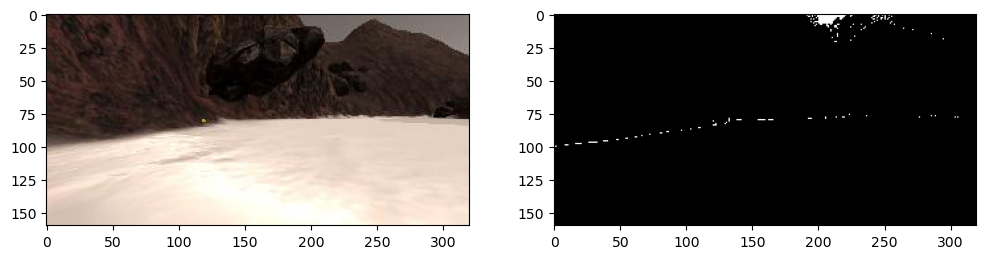

In [8]:
def find_obstacle(img, obs_thresh=(100, 100, 100)):
    color_select = np.zeros_like(img[:,:,0])
    obs = (img[:,:,0] > obs_thresh[0]) & (img[:,:,1] > obs_thresh[1]) & (img[:,:,2] < obs_thresh[2])
    color_select[obs] = 1
    return color_select

idx = np.random.randint(0, len(img_list)-1)
img = mpimg.imread(img_list[idx])
image = find_obstacle(img)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(image, cmap='gray')

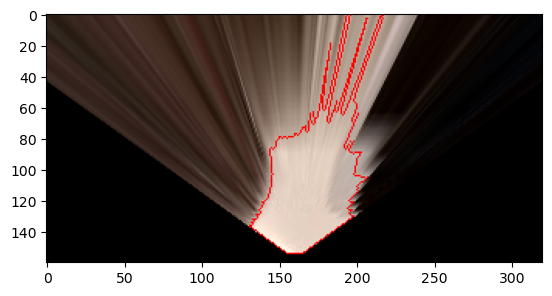

In [9]:
def get_contours(img, rgb_thresh=(170, 170, 170)):
    # get_contours finds all the contours present in the warped image. 
    # with the goal being to find edge between the sand and teh wall.
    # img:           wapred camera image
    # rgb_thresh:    threshold for determing sand / not sand
    
    # Create an array of zeros same xy size as img, but single channel
    thresh_img = np.zeros_like(img[:,:,0])
    # make a copy for finding contours
    imgray = np.copy(img)
    # Require that each pixel be above 2 of the three threshold values in RGB
    # above_thresh will now contain a boolean array with 0-3. 
    above_thresh = (img[:,:,0] > rgb_thresh[0]).astype(int) + \
                   (img[:,:,1] > rgb_thresh[1]).astype(int) + \
                   (img[:,:,2] > rgb_thresh[2]).astype(int)
    
    # create the selection mask where above_thresh is used to select pixels where at least
    # 2 of 3 RGB channels are above threshold
    color_select = (above_thresh > 1).astype(int)
    # assign all elements in thresh_img wehre color_select = 1, to 255
    thresh_img[color_select] = 255
    
    #convert contour image to grayscale
    imgray = cv2.cvtColor(imgray,cv2.COLOR_RGB2GRAY) 
    
    # convert grayscale image for contours to binary image, return imbin as binary image 
    (thresh, imbin) = cv2.threshold(imgray, np.average(rgb_thresh).astype(int), 255, cv2.THRESH_BINARY)
    
    # make a copy (imcont) of the binary image for finding the contours since cv2.findcontours wil modify
    # our source (imbin)
    imcont = np.copy(imbin)
    
    # find the contours, imcont is modified, contours is a list of coordiantes of our contour.
    # the CHAIN_APPROX_NONE ensures we get all points without compression/ extrapolation.
    # hierarchy returns nested contour heirarchies, which we aren't using
    contours, hierarchy = cv2.findContours(imcont,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    return color_select, imbin, contours
nav_img, imbin, contours= get_contours(warped, nav_threshold)
contour = max(contours, key = cv2.contourArea)
imgwcontour = cv2.drawContours(warped, contour,-1, (255,0,0), 1)
plt.imshow(imgwcontour, cmap='gray')

In [10]:
# 1) Define source and destination points for perspective transform
source = np.float32([[13,140], [302,140], [200,96], [118,96]])  #four pixel coords from source image
destination = np.float32([[155,155],[165,155],[165,145],[155,145]]) #four pixel coords from dest image
# 2) Apply perspective transform
warped = perspect_transform(grid_img, source, destination)
roi = np.copy(warped[:, :])  #120, 60:220 worked good for fidelity but mapped slowly so stopped using.
# 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
#GOLD ROCK ~ rgb = 189,144,19 --> 213,183,25 --> 255,219,54
#OBSTACLES ~ rgb = 13,0,0
nav_threshold = (190, 180, 160)
tgt_threshold = (185, 140, 15)
obs_threshold = (100, 100, 100)
tgt_img = color_thresh(warped, tgt_threshold, tgt=True) # used for finding colored rocks
obs_img = color_thresh(warped, obs_threshold) # used for finding obstacles
threshedroi = color_thresh(roi, nav_threshold)   # color threshed roi for mapping.
# Below determines the array used for detecting and trying to prevent collisions
# it masks off only the section right in front of the rover.
coll_roi = np.copy(warped[130:150, 150:170])
coll_roi = cv2.bitwise_not(coll_roi)
coll_roi = color_thresh(coll_roi,obs_threshold)
# 3.5) Retrieve the contours for determining navigation
cont_source = np.copy(warped)
nav_img, imbin, contours= get_contours(cont_source, nav_threshold)
# get the biggest contour (assume that is the one that is navigable, smaller ones are likley obstables / anomolies)
# if no contours present, then return and hope we can pick one up next scan. Pickle logic will kick in eventually


## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [11]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
Rover = Databucket()

/tmp/ipykernel_70466/3650153113.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
/tmp/ipykernel_70466/3650153113.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.worldmap = np.zeros((200, 200, 3)).astype(np.float)


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [12]:
def process_image(img):
    # Perform perception steps to update Rover()
    # NOTE: camera image is coming to you in Rover.img
    
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    #print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])
    xpos = Rover.xpos[data.count]
    ypos = Rover.ypos[data.count]
    yaw  = Rover.yaw[data.count]
    world_size = Rover.worldmap.shape[0]
    
    # 1) Define source and destination points for perspective transform
    source = np.float32([[13,140], [302,140], [200,96], [118,96]])  #four pixel coords from source image
    destination = np.float32([[155,155],[165,155],[165,145],[155,145]]) #four pixel coords from dest image
    
    # 2) Apply perspective transform
    warped = perspect_transform(img, source, destination)
    
    # change [:,:] to mask out portions of warped image if desired
    roi = np.copy(warped[:, :])  #120, 60:220 worked good for fidelity but mapped slowly so stopped using.
    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    #GOLD ROCK ~ rgb = 189,144,19 --> 213,183,25 --> 255,219,54
    #OBSTACLES ~ rgb = 13,0,0
    nav_threshold = (190, 180, 160)
    tgt_threshold = (185, 140, 15)
    obs_threshold = (100, 100, 100)
    tgt_img = color_thresh(warped, tgt_threshold, tgt=True) # used for finding colored rocks
    obs_img = color_thresh(warped, obs_threshold) # used for finding obstacles
    threshedroi = color_thresh(roi, nav_threshold)   # color threshed roi for mapping.
    
    
    # Below determines the array used for detecting and trying to prevent collisions
    # it masks off only the section right in front of the rover.
    coll_roi = np.copy(warped[130:150, 150:170])
    coll_roi = cv2.bitwise_not(coll_roi)
    coll_roi = color_thresh(coll_roi,obs_threshold)
    

    

    # 3.5) Retrieve the contours for determining navigation
    cont_source = np.copy(warped)
    nav_img, imbin, contours= get_contours(cont_source, nav_threshold)
    # get the biggest contour (assume that is the one that is navigable, smaller ones are likley obstables / anomolies)
    # if no contours present, then return and hope we can pick one up next scan. Pickle logic will kick in eventually
    try:
        contour = max(contours, key = cv2.contourArea)
    except:
        #no controus returned... happens occasionally
        return Rover
    
    # Rover is a right wall follower, so mask out parts of the contour
    # that aren't on the right wall:
    nav_roi = contour[contour[:,:,0] > 160] #started at 160
    nav_roi = nav_roi[nav_roi[:,1] > 90] # started at 100
    nav_roi = nav_roi[nav_roi[:,1] < 150] # started at 140 
    xpos_w, ypos_w = nav_roi[:,0], nav_roi[:,1] #Separate out into x & y pixels (w stands for wall here)
    imbin_inv = np.invert(imbin)
    
    # 4) Update Rover.vision_image (this will be displayed on left side of screen)
    #This step taken care of further down after adding some more HUD info to the image
    #Rover.vision_image[:,:,2] = obs_img
    #Rover.vision_image[:,:,1] = tgt_img
    #Rover.vision_image[:,:,0] = msk_img

     
    # 5) Convert map image pixel values to rover-centric coords
    
    xpix_rvr_nav, ypix_rvr_nav = rover_coords(nav_img)
    
    xpix_rvr_tgt, ypix_rvr_tgt = rover_coords(tgt_img) #for rock targets
    xpix_rvr_obs, ypix_rvr_obs = rover_coords(obs_img) #for obstacles
    xpix_rvr_msk, ypix_rvr_msk = rover_coords(threshedroi) #for mappinig
    xpix_rvr_wal, ypix_rvr_wal = rover_coords_(xpos_w, ypos_w, imbin, -3)   #for navigation (contour roi points in rover coordinates)
    xpix_rvr_col, ypix_rvr_col = rover_coords(coll_roi)                          # -10 kept rover too far from wall

    
    # 6) Convert rover-centric pixel values to world coordinates)
    xpos = Rover.xpos[Rover.count]
    ypos = Rover.ypos[Rover.count]
    yaw  = Rover.yaw[Rover.count]
    world_size = Rover.worldmap.shape[0]
    scale = 20 # was 100 --> 60% mapping     40 --> 80% mapping
    #xpix_wrld_nav, ypix_wrld_nav = pix_to_world(xpix_rvr_nav, ypix_rvr_nav, xpos, ypos, yaw, world_size, scale)
    xpix_wrld_tgt, ypix_wrld_tgt = pix_to_world(xpix_rvr_tgt, ypix_rvr_tgt, xpos, ypos, yaw, world_size, scale)
    xpix_wrld_obs, ypix_wrld_obs = pix_to_world(xpix_rvr_obs, ypix_rvr_obs, xpos, ypos, yaw, world_size, scale)
    xpix_wrld_msk, ypix_wrld_msk = pix_to_world(xpix_rvr_msk, ypix_rvr_msk, xpos, ypos, yaw, world_size, scale)
    
    # 7) Update Rover worldmap (to be displayed on right side of screen)
        # Example: Rover.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          Rover.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          Rover.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    Rover.worldmap[ypix_wrld_obs.astype(int), xpix_wrld_obs.astype(int), 0] = 255
    Rover.worldmap[ypix_wrld_tgt.astype(int), xpix_wrld_tgt.astype(int), 1] = 255
    Rover.worldmap[ypix_wrld_msk.astype(int), xpix_wrld_msk.astype(int), 2] = 255
   
    # 8) Convert rover-centric pixel positions to polar coordinates
    # Update Rover pixel distances and angles
    Rover.wal_dists, Rover.wal_angles = to_polar_coords(xpix_rvr_wal, ypix_rvr_wal)
    Rover.nav_dists, Rover.nav_angles = to_polar_coords(xpix_rvr_nav, ypix_rvr_nav)
    Rover.tgt_dists, Rover.tgt_angles = to_polar_coords(xpix_rvr_tgt, ypix_rvr_tgt)
    Rover.col_dists, Rover.col_angles = to_polar_coords(xpix_rvr_col, ypix_rvr_col)
    
    
   
    
    # update an image to include our navigation data on HUD
    # Draw the entire contour on imgwcontour
    imgwcontour = cv2.drawContours(cont_source, contour,-1, (255,0,0), 1)
    
    # highlight the wall pixels we are navigating to 
    #(should match up exactly with a portion of the contour drawn above)
    imgwcontour[ypos_w,xpos_w, 1:2] = 255
    
    # (Show the current nav angle to the wall pixels
    cv2.putText(imgwcontour,"NavAngle To Wall: " + str(np.mean(Rover.wal_angles * 180/np.pi))[:4], (0, 20), 
                  cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
    
    # Show the average distances to the masked wall pixels. [:4] limits the string to 3 significant digits
    cv2.putText(imgwcontour,"NavPixels: " + str(len(Rover.nav_dists)), (0, 40), 
                  cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
    

    cv2.putText(imgwcontour,"Mode: ", (0, 60), 
                cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
    cv2.putText(imgwcontour,"Pickle: ", (0, 80), 
                cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
    cv2.putText(imgwcontour,"col_pix: ", (0, 100), 
                cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
    cv2.putText(imgwcontour,"near_sample: ", (0, 120), 
                cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 255, 255), 1)
    if tgt_img.any():
        cv2.putText(imgwcontour,"SAMPLE DETECTED", (0, 140),
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    #imgwcontour[obs_nav_xpix.astype(int), obs_nav_ypix.astype(int), 0:2] = 255
    Rover.vision_image = imgwcontour
    
    
    
    
    
    
    
    output_image = np.zeros((img.shape[0] + Rover.worldmap.shape[0], img.shape[1]*2, 3))
    output_image[0:img.shape[0], 0:img.shape[1]] = img
    warped = perspect_transform(img, source, destination)
    output_image[0:img.shape[0], img.shape[1]:] = warped
    map_add = cv2.addWeighted(Rover.worldmap, 1, Rover.ground_truth, 0.5, 0)
    output_image[img.shape[0]:, 0:Rover.worldmap.shape[1]] = np.flipud(map_add)
    # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if Rover.count < len(Rover.images) - 1:
        Rover.count += 1 # Keep track of the index in the Databucket()
    
    return output_image
    

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy import *
from moviepy.editor import *
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = 'test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

Moviepy - Building video test_mapping.mp4.
Moviepy - Writing video test_mapping.mp4



Moviepy - Done !
Moviepy - video ready test_mapping.mp4
CPU times: user 14.9 s, sys: 354 ms, total: 15.3 s
Wall time: 46.4 s


In [14]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))